# 🧬 + 🤖 **Hello Evo**: From DNA generation to protein folding


Evo is a 7B long-context biological foundation model that generalizes across the fundamental languages of biology: DNA, RNA, and proteins. It is capable of both prediction tasks and generative design, from molecular to whole genome scale (generating over 650k tokens). We trained Evo at a single-nucleotide (byte) resolution, on a large corpus of prokaryotic and phage sequences covering 2.7 million genomes.

Evo is based on the [StripedHyena](https://www.together.ai/blog/stripedhyena-7b) architecture to enable modeling of sequences at byte-level resolution with near-linear scaling of compute and memory relative to context length.

Learn more about Evo here:
- 📄 [Preprint](https://www.biorxiv.org/content/10.1101/2024.02.27.582234v1)
- 🌐 [Blog](https://arcinstitute.org/news/blog/evo)
- 💽 [GitHub](https://github.com/evo-design/evo)
- 🎨 [Generate DNA in the Browser](https://api.together.xyz/playground/language/togethercomputer/evo-1-131k-base)
- 🤗 [Checkpoint](https://huggingface.co/togethercomputer/evo-1-131k-base)


## 👉 Before you start:
We will use the [Together AI API](https://docs.together.ai/docs/quickstart) to generate DNA with Evo.
To run this colab, you will thus need to set up an account with Together AI:
[www.together.ai](https://www.together.ai/).
Don't worry, you will get some free compute credits when signing up!

🖖 If you don't want to sign up, we also provide a script demonstrating the process from DNA generation to protein folding using our model checkpoints hosted on HuggingFace and only local hardware: [github.com/evo-design/evo/scripts/generation_to_folding.py](https://github.com/evo-design/evo/blob/main/scripts/generation_to_folding.py)

*This colab was created by [Armin Thomas](https://athms.me) in Feb. `24.*

# 1. Installs and Dependencies

In [ ]:
# Before we begin, we need to install prodigal, which we will use later
# to predict protein-coding genes from our generated DNA sequences.
# We install prodigal through conda, which might take a few minutes...
!pip install -q condacolab # -> condacolab allows us to install with conda
import condacolab
condacolab.install()
!conda install -c bioconda prodigal

In [ ]:
# We also need to install a few more python dependencies:
# ...this might also take a few minutes...
!pip install together accelerate biopython biotite py3Dmol

In [6]:
# Ok, we are ready to begin and import all tools we will use in this colab:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import py3Dmol # -> used to visualize protein structures
import together # -> to call the API
# ↓ Tools to process DNA and protein data
import biotite.structure.io as bsio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
# ↓ To load ESMFold from HuggingFace, which we use to predict protein foldings
from transformers import (
  AutoTokenizer,
  EsmForProteinFolding,
  set_seed
)

# Let's also enable TensorFloat32 computation for some speedups:
torch.backends.cuda.matmul.allow_tf32 = True

# 2. Setting up the API and your prompt

In [7]:
# We begin by setting some key variables for our code:

# 1. Together API key:
# You can find your API key under Settings -> API keys @www.together.ai
TOGETHER_API_KEY = '' # <- insert your key here!
assert len(TOGETHER_API_KEY)>0, 'Please provide a Together API key.'

# 2. Key arguments for generating DNA with Evo:
evo_name = 'togethercomputer/evo-1-131k-base' # -> base model with 131k context
# the model with 8k context is called by: 'togethercomputer/evo-1-8k-base'

# Our prompting scheme follows "Greengenes-style lineage strings",
# which concatenate all taxa starting with the most ancestral and ending
# with the most current, separated by semicolons. A single character
# prefix is also added to each taxon indicating its rank.
# For more information, see:
# https://github.com/qiyunzhu/woltka/blob/main/doc/hierarchy.md#3-lineage-strings---lineage
prompt = (
  "|" # -> start prompt
  +"d__Bacteria;"
  +"p__Pseudomonadota;"
  +"c__Gammaproteobacteria;"
  +"o__Enterobacterales;"
  +"f__Enterobacteriaceae;"
  +"g__Escherichia;"
  +"s__Escherichia"
  +"|" # -> end prompt
)
# ...so cool that we can use natural language-like prompts for Evo!!
# ----
# /!\ IMPORTANT:
# The 8k context model does not allow for this kind of prompting scheme!
# It can, however, be used to predict continuations for DNA sequences
# that you provide as input.
# ----

# ↓ A few more variables to control the generation process
max_tokens = 1024 # we want to generate maximally 1024 new tokens
temperature = 1. # The sampling temperature (between 0 and 2) controls
# the randomness with which the model picks tokens during generation.
# Higher values (eg, >1) will make the generations more diverse (-> more random).
# Lower values (eg, <1) will make them less diverse (-> more deterministic).
top_k = 4 # Specifies the maximum number of tokens to be considered at each
# generation step, based on their probability of occurrence.
# This can help speed up the generation process and improve
# the quality of the generated tokens by focusing on the most likely options.
top_p = 1. # As an alternative to the sampling temperature, we can also set
# the "top_p" parameter. The model only considers the those tokens for
# generation that contain the top_p probability mass.
# Eg, with top_p = 0.1, the model only considers the tokens comprising
# the top 10% probability -> leading to generally less diverse generations.
# When top_p = 1, all tokens are considered -> more diverse generations.

# ~ We generally recommend to set temperature = top_p = 1 and top_k = 4 ~

# 3. Paths to local files that we will generate:
sequence_fasta = './sequence.fasta'
proteins_fasta = './proteins.fasta'
protein_structure_pdb = './protein_structure.pdb'
# Learn more about the .fasta format here:
# https://en.wikipedia.org/wiki/FASTA_format

# 4. Misc arguments:
device = 'cuda'
seed = 123456789

In [8]:
# We try our best to make this code reproducible:
torch.manual_seed(seed) # pytorch random seed
set_seed(seed) # huggingface random seed

In [9]:
# These are some additional prompt examples for the 131k model:

# prompt2 = "|d__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Mycoplasma;s__Mycoplasma genitalium|"
# prompt3 = "|d__Bacteria;p__Bacillota;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus aureus|"

# 3. Calling the Together API

In [10]:
# We are now ready to generate DNA with Evo, using the Together API.
# To call the API, we will use the together python package:

# 1. Make your API key accessible to the together library:
together.api_key = TOGETHER_API_KEY

# 2. Specify the message to be sent to Evo:
output = together.Complete.create(
  prompt = prompt,
  model = evo_name,
  # ↓ our generation paramaters
  max_tokens = max_tokens,
  temperature = temperature,
  top_k = top_k,
  top_p = top_p,
  logprobs = True # lets also collect the log probs for the generated tokens
)
# ----
# /!\ IMPORTANT:
# Please note that we currently cannot set a random seed
# when prompting the Together API. For this reason, we also
# cannot guarantee reproducible results.
# ----

# Learn more about the together python library here:
# https://docs.together.ai/docs/inference-python

In [11]:
# This is how Evo's generated DNA sequence looks like:
gen_dna_seq = output['choices'][0]['text']
print('Generated DNA sequence: ',gen_dna_seq)

Generated DNA sequence:  TACAACGAGCAGCAACACAGATTCAATGAGAAAGAGAAANTAAAGATCATGACACAACGAAATTTGCAAATTTTTGAAGATGAACCAAACATTGCATAAAACCGTAAACCCGCGACCGTCATGAACCCGTTCCCTTGTCAGAAGAGACCTGAAAACTACGAAGATTGGATCCGTGGAGTCAAATGGCCAATSTATAAAAACCNCCGTTACAGACGGCCACGGCCCATGGGGGGGGGGCTGACAATACATCAAAACGGCGCCTGCAAAACGCTGCAAAGGAACAATGCGAACCACAGCGCGACCCGCAAGGGGGCGCCAGACAGACCATCCCCATCACCGCAGGGCGGCACCCCAAAAATGCCCCCGATAAAACGACCAAATGTCACGGGACTACCTGCATCACTCAACACCGCCCCCCCAGGCAGCCCAAACGTTCACGCTTTTAAAGAAGAGCTTAACGCAACCGAGCAGGCTCCGCCTTCGTCCGCACCTCCGAATAGAGAACGACCAGACGAAGGGCACTCTAGCTGCTCGTGCAAGTAGCGTCGCCTAGAACTCCCCGTCCATTATGGCAGCGGCCCTATAAAACGACTTGAAAGCCCGCGTAAACCGTCCGCACAGCCCTCACGGCCTTCTGGTCCTAGTAGGGGGAACAAAACGGCACACGGCCAAACCTCCGCTGCCGCCTGGCCCCCCGCCTGTATTCCACCAGGAGCACCCACGATACAGACGGGAGAGTGGCGAAGAAAAGCCGCAAACGAAGCGTTTCGAAGGAGGCCCAGAAACCTCTGGAACCAACGTGACCACGCTCGCCAACCCATTTAAAAGCCAGAGAATAACACACAGGCCGTTGTTAAAACATAAAAAAGCCAAACAAGCCCTACAAGAACTTTTCCAAACTCCAAGAGGAGCGCCGCTACCAGCACCCACCCACCGCCGCTGACGCTGATCATAAGACGTAAGCTGACCCACACG

# 4. Analyzing the generated DNA sequence

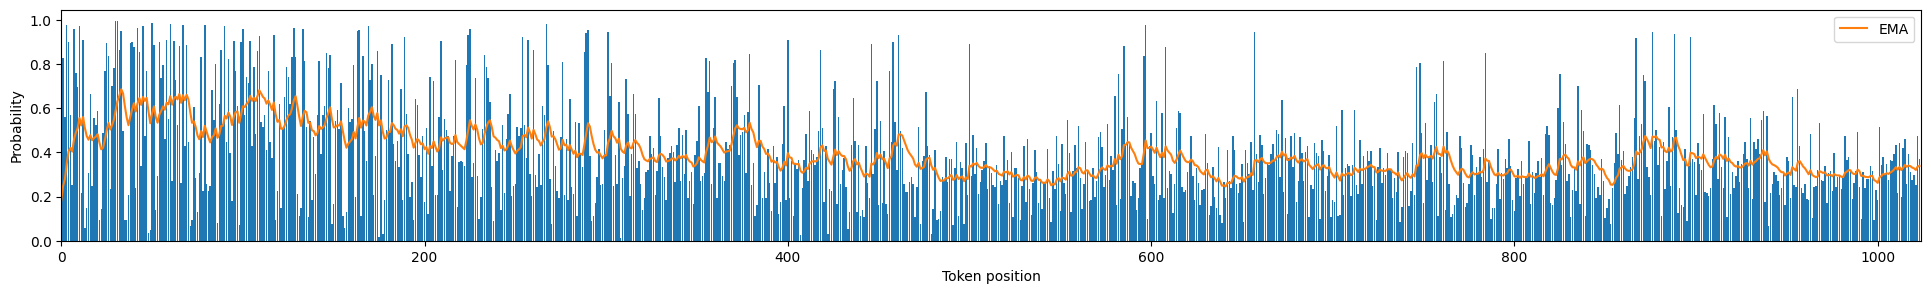

In [12]:
# We can also take a peak at the log probabilities for each generated token:

# 1. Extract probabilities:
gen_dna_logprobs = output['output']['choices'][0]['token_logprobs']
gen_dna_probs = np.exp(gen_dna_logprobs)

# 2. Compute exponential moving average over probabilities (for plotting):
def exponential_moving_average(x, alpha: float=0.1):
  """little helper to compute exponential moving average over input array x"""
  ema = [x[0]]
  for i in range(1, len(x)):
      ema_value = alpha * x[i] + (1 - alpha) * ema[i - 1]
      ema.append(ema_value)
  return np.array(ema)

ema_gen_dna_probs = exponential_moving_average(gen_dna_probs)

# 3. Plot probabilities & EMA:
fig, ax = plt.subplots(1,1,figsize=(24,3))
ax.bar(np.arange(gen_dna_probs.shape[0]), gen_dna_probs, color='C0')
ax.plot(ema_gen_dna_probs, color='C1', label='EMA')
ax.set_xlabel('Token position')
ax.set_ylabel('Probability')
ax.set_xlim(0, max_tokens)
ax.legend()

In [13]:
# We save the generated DNA sequence to a local .fasta file.
# This will make it easier to digest for prodigal (see below).
gen_dna_seq_record = SeqRecord(
  Seq(gen_dna_seq),
  id="evo-dna",
  description="DNA sequence generated by Evo."
)
with open(sequence_fasta, "w") as output_handle:
  SeqIO.write(gen_dna_seq_record, output_handle, "fasta")

In [14]:
# This is how the sequence_fasta file looks like:
!cat '{sequence_fasta}'

>evo-dna DNA sequence generated by Evo.
TACAACGAGCAGCAACACAGATTCAATGAGAAAGAGAAANTAAAGATCATGACACAACGA
AATTTGCAAATTTTTGAAGATGAACCAAACATTGCATAAAACCGTAAACCCGCGACCGTC
ATGAACCCGTTCCCTTGTCAGAAGAGACCTGAAAACTACGAAGATTGGATCCGTGGAGTC
AAATGGCCAATSTATAAAAACCNCCGTTACAGACGGCCACGGCCCATGGGGGGGGGGCTG
ACAATACATCAAAACGGCGCCTGCAAAACGCTGCAAAGGAACAATGCGAACCACAGCGCG
ACCCGCAAGGGGGCGCCAGACAGACCATCCCCATCACCGCAGGGCGGCACCCCAAAAATG
CCCCCGATAAAACGACCAAATGTCACGGGACTACCTGCATCACTCAACACCGCCCCCCCA
GGCAGCCCAAACGTTCACGCTTTTAAAGAAGAGCTTAACGCAACCGAGCAGGCTCCGCCT
TCGTCCGCACCTCCGAATAGAGAACGACCAGACGAAGGGCACTCTAGCTGCTCGTGCAAG
TAGCGTCGCCTAGAACTCCCCGTCCATTATGGCAGCGGCCCTATAAAACGACTTGAAAGC
CCGCGTAAACCGTCCGCACAGCCCTCACGGCCTTCTGGTCCTAGTAGGGGGAACAAAACG
GCACACGGCCAAACCTCCGCTGCCGCCTGGCCCCCCGCCTGTATTCCACCAGGAGCACCC
ACGATACAGACGGGAGAGTGGCGAAGAAAAGCCGCAAACGAAGCGTTTCGAAGGAGGCCC
AGAAACCTCTGGAACCAACGTGACCACGCTCGCCAACCCATTTAAAAGCCAGAGAATAAC
ACACAGGCCGTTGTTAAAACATAAAAAAGCCAAACAAGCCCTACAAGAACTTTTCCAAAC
TCCAAGAGGAGCGCCGCTACCAGCACCCACCCACCGCCGCTGACG

# 5. Predicting protein-coding genes from the DNA sequence

In [15]:
# To predict protein-coding genes from our DNA sequence, we use prodigal.
# We run prodigal as a shell command, using the sequence_fasta as input,
# and saving the results to another fasta file (-> proteins_fasta):
!prodigal -i '{sequence_fasta}' -a '{proteins_fasta}' -o 'genes.gff' -p 'meta' -f 'gff'

# Learn more about prodigal here: https://github.com/hyattpd/prodigal/wiki

-------------------------------------
PRODIGAL v2.6.3 [February, 2016]         
Univ of Tenn / Oak Ridge National Lab
Doug Hyatt, Loren Hauser, et al.     
-------------------------------------
Request:  Metagenomic, Phase:  Training
Initializing training files...done!
-------------------------------------
Request:  Metagenomic, Phase:  Gene Finding
Finding genes in sequence #1 (1024 bp)...done!


In [16]:
# This is how our saved proteins_fasta file looks like:
!cat '{proteins_fasta}'

>evo-dna_1 # 1 # 294 # -1 # ID=1_1;partial=10;start_type=GTG;rbs_motif=None;rbs_spacer=None;gc_cont=0.469
MVRIVPLQRFAGAVLMYCQPPPHGPWPSVTXVFIXWPFDSTDPIFVVFRSLLTRERVHDG
RGFTVLCNVWFIFKNLQISLCHDLXFLFLIESVLLLVV
>evo-dna_2 # 822 # 1022 # -1 # ID=1_2;partial=01;start_type=Edge;rbs_motif=None;rbs_spacer=None;gc_cont=0.527
RCSAVGDLGCSLGGCVVWVSLRLMISVSGGGWVLVAALLLEFGKVLVGLVWLFYVLTTAC
VLFSGF*


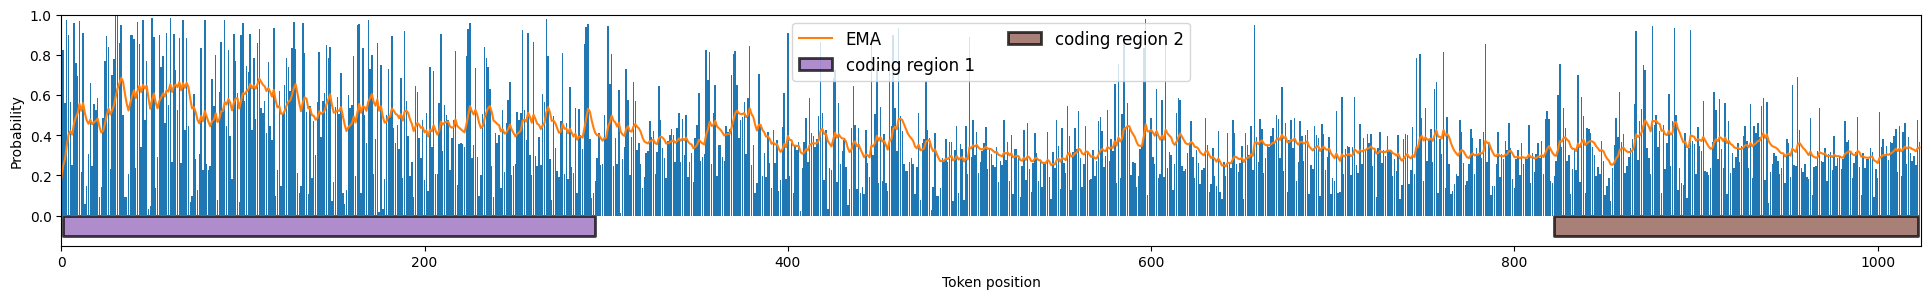

In [17]:
# Let's also see where these predicted protein-coding genes
# lie on our generated DNA sequence:

# 1. Read protein-coding gene coordinates from the .fasta file:
def load_fasta(file_path):
  """a little helper to load records from a .fasta file"""
  sequences = []
  with open(file_path, "r") as handle:
      for record in SeqIO.parse(handle, "fasta"):
          sequences.append(record)
  return sequences

def extract_start_end_coords(sequences):
  """a little helper to extract the start and
  end coordinates of the predicted protein-coding
  genes"""
  coordinates = []
  for record in sequences:
      start, end = map(int, [info.strip() for info in record.description.split('#')[1:3]])
      coordinates.append((start, end))
  return coordinates

gene_seqs = load_fasta(proteins_fasta)
gene_coords = extract_start_end_coords(gene_seqs)

# 2. Add coordinates to our previous token probability plot:
fig, ax = plt.subplots(1,1,figsize=(24,3))
ax.bar(np.arange(gen_dna_probs.shape[0]), gen_dna_probs, color='C0')
ax.plot(ema_gen_dna_probs, color='C1', label='EMA')
for ci, coords in enumerate(gene_coords):
   ax.fill_between(
    coords,
    -.1, 0,
    color=f'C{4+ci}',
    alpha=0.75,
    edgecolor='k',
    linewidth=2,
    label=f'coding region {ci+1}',
    zorder=-99
  )
ax.set_xlabel('Token position')
ax.set_ylabel('Probability')
ax.set_xlim(0, max_tokens)
ax.set_ylim(-0.15, 1)
ax.legend(frameon=True, loc='upper center', ncols=2, fontsize='large')

# 6. Predicting protein structures

In [18]:
# To fold our predicted protein-coding genes, we use ESMFold,
# as recently published by Meta:
# https://www.science.org/doi/abs/10.1126/science.ade2574

# Luckily, ESMFold is hosted on HuggingFace,
# so loading and using the model is a breeze:
# ~ Open source for the win! ~
esmfold = EsmForProteinFolding.from_pretrained(
  "facebook/esmfold_v1",
  low_cpu_mem_usage = True # we set this flag to save some RAM during loading
)
esmfold = esmfold.to(device) # -> move ESMFold to the GPU
esmfold.esm = esmfold.esm.half() # -> make sure we use a lightweight precision

/usr/local/lib/python3.10/site-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/8.44G [00:00<?, ?B/s]

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# We will also need the ESMFold tokenizer to map our predicted protein-coding
# genes to the token vocabulary of ESMFold:
esmfold_tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [20]:
# Using ESMFold, we can easily predict a protein folding structure:

# 1. Select a predicted protein-coding gene that we want to fold:
i = 0 # lets just use the first one.
protein_record = list(SeqIO.parse(proteins_fasta, "fasta"))[i]
protein_seq = str(protein_record.seq)[:-1] # remove stop codon

# 2. Tokenize the gene to make it digestible for ESMFold:
esmfold_in = esmfold_tokenizer(
  [protein_seq],
  return_tensors="pt",
  add_special_tokens=False
)

# 3. Feed the tokenized sequence to ESMfold:
# (in PyTorch's inference_mode to avoid any costly gradient computations)
with torch.inference_mode():
  esmfold_out = esmfold(**esmfold_in.to(device))
  esmfold_out_pdb = esmfold.output_to_pdb(esmfold_out)[0]

In [21]:
# This is how our predicted protein structure looks like in numbers:
with open(protein_structure_pdb, "w") as f:
  f.write(esmfold_out_pdb)

protein_structure = bsio.load_structure(
  protein_structure_pdb,
  extra_fields=["b_factor"]
)
print('Generated protein structure: ', protein_structure)

Generated protein structure:      A       1  MET N      N        -1.658   20.505    6.157
    A       1  MET CA     C        -2.361   20.300    4.895
    A       1  MET C      C        -1.650   19.256    4.039
    A       1  MET CB     C        -2.479   21.615    4.123
    A       1  MET O      O        -0.455   19.381    3.766
    A       1  MET CG     C        -3.547   21.599    3.042
    A       1  MET SD     S        -3.770   23.238    2.249
    A       1  MET CE     C        -4.370   22.725    0.615
    A       2  VAL N      N        -2.091   17.938    4.022
    A       2  VAL CA     C        -1.481   16.881    3.222
    A       2  VAL C      C        -1.667   17.183    1.737
    A       2  VAL CB     C        -2.077   15.496    3.563
    A       2  VAL O      O        -2.769   17.521    1.299
    A       2  VAL CG1    C        -1.424   14.404    2.718
    A       2  VAL CG2    C        -1.911   15.196    5.051
    A       3  ARG N      N        -0.495   17.498    1.016
    A     

In [22]:
# ...but it's much nicer to look at as a graphic :-)
view = py3Dmol.view(
  js='https://3dmol.org/build/3Dmol.js',
  width=800,
  height=400
)
view.addModel("".join(esmfold_out_pdb), 'pdb')
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# 🍭 Stay tuned!

We are planning to open source more Evo models over time, including finetuned models for creating CRISPR systems and mobile genetic elements.

An important part of the Evo generation pipeline is to screen/filter for high quality samples. We utilize a number of existing (and amazing!) tools for this, like [Prodigal](https://github.com/hyattpd/Prodigal), [CheckM](https://ecogenomics.github.io/CheckM/), and [BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi). Going forward, we plan to incorporate these more into our public codebase and modeling pipelines, hoping to provide useful and openly available tools for the community. We are looking forward to this journey and invite you to join us!